Docs: https://pyimagesearch.com/2018/06/04/keras-multiple-outputs-and-multiple-losses/

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Setup

In [ ]:
%%capture
!pip install remotezip tqdm opencv-python
# !pip install mediapipe
!pip install -q git+https://github.com/tensorflow/docs
!pip install -q mediapy

In [ ]:
import os
import shutil
import cv2
import math
import random
import numpy as np
import datetime as dt
import tensorflow as tf
import keras
from collections import deque
import matplotlib.pyplot as plt
import h5py
plt.style.use("seaborn")

%matplotlib inline

from sklearn.model_selection import train_test_split

from keras.layers import *
from keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
# from keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Flatten, Dense, BatchNormalization, Lambda
# from tensorflow.keras.models import load_model

<ipython-input-1-10bb233cb99c>:13: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


In [ ]:
# Check if GPU enabled
print("GPU acceleration enabled:", tf.test.is_built_with_cuda())

GPU acceleration enabled: True


In [ ]:
# turn off warning
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# !ls /content/drive/MyDrive/models/plugin-for-kids/20122023

human-prediction.keras	mobilenet.keras  phase1-model.keras


# Download data

**@ Way to use kaggle download dataset in colab**


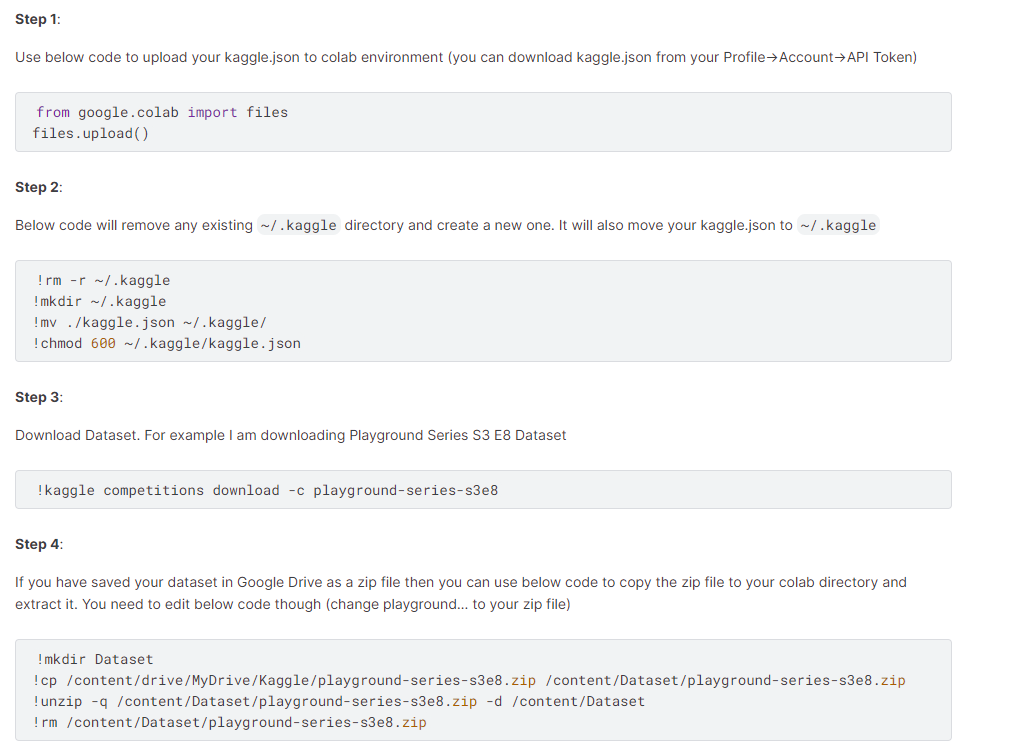

In [ ]:
# Upload kaggle key
from google.colab import files
files.upload()

# !rm -r ~/.kaggle

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"vinhdnvn1202","key":"b009fbca7f9dfada2b17c85be3d86035"}'}

In [ ]:

!mkdir ~/.kaggle
!mv ./kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
!kaggle datasets download -d vinhdnvn1202/human-v1-small

 97% 283M/291M [00:02<00:00, 139MB/s]
100% 291M/291M [00:02<00:00, 120MB/s]


In [ ]:

!kaggle datasets download -d vinhdnvn1202/violence-v1-small

 99% 373M/377M [00:08<00:00, 57.6MB/s]
100% 377M/377M [00:08<00:00, 44.8MB/s]


In [ ]:
!unzip /content/violence-v1-small.zip

In [ ]:
!unzip /content/human-v1-small.zip

In [ ]:
!mv /content/3 /content/drive/MyDrive/dacs4/Datasets/plugin-for-kids/dataset/human_vinh_v1

In [ ]:
!mv /content/violence_dataset /content/drive/MyDrive/dacs4/Datasets/plugin-for-kids/dataset/violence_vinh_v1

# Prepare

In [ ]:
#@title Constant
root_path = "/content"

human_dir =  os.path.join(root_path, "drive/MyDrive/dacs4/Datasets/plugin-for-kids/dataset/human_vinh_v1/3/human")
non_human_dir =  os.path.join(root_path, "drive/MyDrive/dacs4/Datasets/plugin-for-kids/dataset/human_vinh_v1/3/non-human")

violence_dir = os.path.join(root_path, "/content/drive/MyDrive/dacs4/Datasets/plugin-for-kids/dataset/violence_vinh_v1/violence_dataset/violence")
non_violence_dir = os.path.join(root_path, "/content/drive/MyDrive/dacs4/Datasets/plugin-for-kids/dataset/violence_vinh_v1/violence_dataset/non_violence")

# normal_dir =  os.path.join(root_path, "data/normal")
# violence_dir = os.path.join(root_path, "data/violence")
# weapon_dir =  os.path.join(root_path, "data/weapon")

IMG_SIZE = 128
BATCH_SIZE = 16



In [ ]:
#@title Functions

def get_data(data_path):
  data = []
  for current_dir, dir_names, filenames in os.walk(data_path):
    for filename in filenames:
        img = cv2.imread(os.path.join(current_dir, filename))
        img = cv2.resize(
            img, dsize=(IMG_SIZE, IMG_SIZE),
            interpolation=cv2.INTER_CUBIC
        )
        img = preprocess_input(img)
        data.append(img)

  data = np.array(data)

  return data

In [ ]:
#@title Load human data
human_data = get_data(human_dir)
non_human_data = get_data(non_human_dir)

print(human_data.shape)
print(non_human_data.shape)

(1923, 128, 128, 3)
(1421, 128, 128, 3)


In [ ]:
#@title Load violence data
violence_data = get_data(violence_dir)
non_violence_data = get_data(non_violence_dir)

print(violence_data.shape)
print(non_violence_data.shape)

(2566, 128, 128, 3)
(2521, 128, 128, 3)


In [ ]:
#@title Save human data
def save_data(data, path):
    np.save(path, data)

save_data(human_data, '/content/drive/MyDrive/dacs4/Datasets/plugin-for-kids/human-data.npy')
save_data(non_human_data, '/content/drive/MyDrive/dacs4/Datasets/plugin-for-kids/non-human-data.npy')

In [ ]:
#@title Save violence data
def save_data(data, path):
    np.save(path, data)


save_data(violence_data, '/content/drive/MyDrive/dacs4/Datasets/plugin-for-kids/violence-data.npy')
save_data(non_violence_data, '/content/drive/MyDrive/dacs4/Datasets/plugin-for-kids/non-violence-data.npy')

In [ ]:
#@title Remove redundant variables
del human_data
del non_human_data
del violence_data
del non_violence_data

In [ ]:
#@title Label human data
human_labels = np.concatenate((np.ones(human_data.shape[0]),
                                  np.zeros(non_human_data.shape[0])),
                                 axis=0)
np.save(os.path.join(root_path, 'drive/MyDrive/dacs4/Datasets/plugin-for-kids/human-labels.npy'), human_labels)

In [ ]:
#@title Label violence data
violence_labels = np.concatenate((np.ones(violence_data.shape[0]),
                                  np.zeros(non_violence_data.shape[0])),
                                 axis=0)
np.save(os.path.join(root_path, 'drive/MyDrive/dacs4/Datasets/plugin-for-kids/violence_labels.npy'), violence_labels)

# Train

## Single phase (current)

> Indented block



In [ ]:
#@title Load data
human_data = np.load('/content/drive/MyDrive/dacs4/Datasets/plugin-for-kids/human-data.npy')
non_human_data = np.load('/content/drive/MyDrive/dacs4/Datasets/plugin-for-kids/non-human-data.npy')

violence_data = np.load('/content/drive/MyDrive/dacs4/Datasets/plugin-for-kids/violence-data.npy')
non_violence_data = np.load('/content/drive/MyDrive/dacs4/Datasets/plugin-for-kids/non-violence-data.npy')

data = np.concatenate([human_data, non_human_data, violence_data, non_violence_data])
# human_data.shape, non_human_data.shape, violence_data.shape, non_violence_data.shape

In [ ]:
#@title Load labels
human_labels = np.concatenate([
    np.ones(human_data.shape[0]),
    np.zeros(non_human_data.shape[0]),
    np.ones(violence_data.shape[0]),
    np.ones(non_violence_data.shape[0]),
])
violence_labels = np.concatenate([
    np.zeros(human_data.shape[0]),
    np.zeros(non_human_data.shape[0]),
    np.ones(violence_data.shape[0]),
    np.zeros(non_violence_data.shape[0]),
])

human_labels = np.array(tf.one_hot(human_labels, depth=2))
violence_labels = np.array(tf.one_hot(violence_labels, depth=2))

labels = np.array([human_labels, violence_labels])
labels = np.swapaxes(labels, 0, 1)

# human_labels.shape, violence_labels.shape

In [ ]:
# swap axes for splitting

# labels.shape

In [ ]:
#@title Split to training and validation
train_data, val_data, train_labels, val_labels = train_test_split(data, labels, test_size=0.4)

In [ ]:
#@title convert data, labels to tensor
train_data = tf.convert_to_tensor(train_data, dtype=tf.float32)
val_data = tf.convert_to_tensor(val_data, dtype=tf.float32)

train_human_labels = tf.convert_to_tensor(train_labels[:,0], dtype=tf.int32)
train_violence_labels = tf.convert_to_tensor(train_labels[:,1], dtype=tf.int32)
val_human_labels = tf.convert_to_tensor(val_labels[:,0], dtype=tf.int32)
val_violence_labels = tf.convert_to_tensor(val_labels[:,1], dtype=tf.int32)

labels = {
    'human_output': train_human_labels,
    'violence_output': train_violence_labels
}

val_labels = {
    'human_output': val_human_labels,
    'violence_output': val_violence_labels
}

train_data.shape, train_human_labels.shape, train_violence_labels.shape

(TensorShape([5058, 128, 128, 3]),
 TensorShape([5058, 2]),
 TensorShape([5058, 2]))

In [ ]:
# val_data.shape, val_human_labels.shape, val_violence_labels.shape

In [ ]:
IMG_SIZE =128

In [ ]:
#@title Build model
from keras.applications.mobilenet_v2 import MobileNetV2

mobilenet = MobileNetV2(include_top=False, weights=None, input_tensor=Input(shape=(IMG_SIZE, IMG_SIZE, 3)), input_shape=(IMG_SIZE, IMG_SIZE, 3))
mobilenet.trainable = True

head_model = mobilenet.output
head_model = GlobalAveragePooling2D()(head_model)

human_output = Dense(512, activation='relu')(head_model)
# human_output = Dropout(0.4)(human_output)
human_output = Dense(128, activation='relu')(human_output)
human_output = Dense(2, activation='softmax', name='human_output')(human_output)

violence_output = Dense(512, activation='relu')(head_model)
# violence_output = Dropout(0.4)(violence_output)
violence_output = Dense(128, activation='relu')(violence_output)
violence_output = Dense(2, activation='softmax', name='violence_output')(violence_output)

model = keras.Model(inputs=mobilenet.input, outputs=[human_output, violence_output])

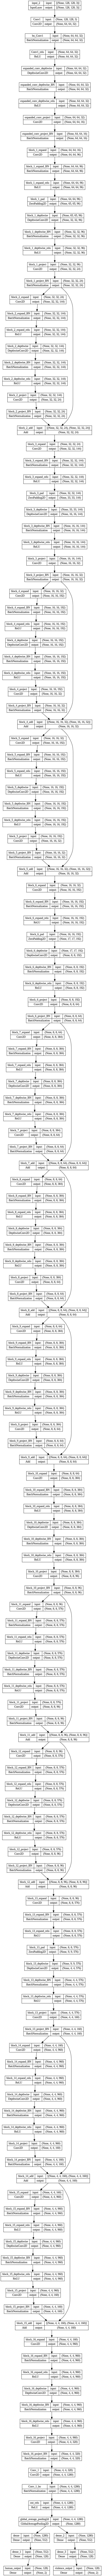

In [ ]:
plot_model(model, show_shapes = True, show_layer_names = True)

In [ ]:
#@title Complile
base_learning_rate = 1e-3

model.compile(optimizer=keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

In [ ]:
model.inputs, model.outputs

([<KerasTensor: shape=(None, 128, 128, 3) dtype=float32 (created by layer 'input_1')>],
 [<KerasTensor: shape=(None, 2) dtype=float32 (created by layer 'human_output')>,
  <KerasTensor: shape=(None, 2) dtype=float32 (created by layer 'violence_output')>])

In [ ]:
#@title Training
def lr_schedule(epoch):
    if epoch < 30:
        return base_learning_rate
    elif (epoch >= 30) and (epoch < 70):
        return 5e-4
    elif (epoch >= 70) and (epoch < 120):
        return 1e-4
    elif (epoch >= 120) and (epoch < 180):
        return 5e-5
    elif (epoch >= 180) and (epoch < 250):
        return 1e-5
    elif (epoch >= 250) and (epoch < 340):
        return 5e-6
    else:
        return 1e-6

# down learning rate
lr_scheduler = keras.callbacks.LearningRateScheduler(lr_schedule)

history = model.fit(x=train_data, y=labels,
                        epochs=100,
                        batch_size=32,
                        validation_data=(val_data, val_labels),
                        callbacks=[lr_scheduler])

Epoch 1/100
159/159 [==============================] - 46s 94ms/step - loss: 0.9718 - human_output_loss: 0.4137 - violence_output_loss: 0.5581 - human_output_accuracy: 0.8371 - violence_output_accuracy: 0.7191 - val_loss: 1.2618 - val_human_output_loss: 0.5991 - val_violence_output_loss: 0.6627 - val_human_output_accuracy: 0.8346 - val_violence_output_accuracy: 0.6958 - lr: 0.0010
Epoch 2/100
159/159 [==============================] - 11s 71ms/step - loss: 0.7335 - human_output_loss: 0.3032 - violence_output_loss: 0.4303 - human_output_accuracy: 0.8800 - violence_output_accuracy: 0.7995 - val_loss: 1.1080 - val_human_output_loss: 0.4703 - val_violence_output_loss: 0.6378 - val_human_output_accuracy: 0.8346 - val_violence_output_accuracy: 0.6958 - lr: 0.0010
Epoch 3/100
159/159 [==============================] - 11s 71ms/step - loss: 0.6479 - human_output_loss: 0.2759 - violence_output_loss: 0.3720 - human_output_accuracy: 0.8934 - violence_output_accuracy: 0.8308 - val_loss: 1.0807 - v

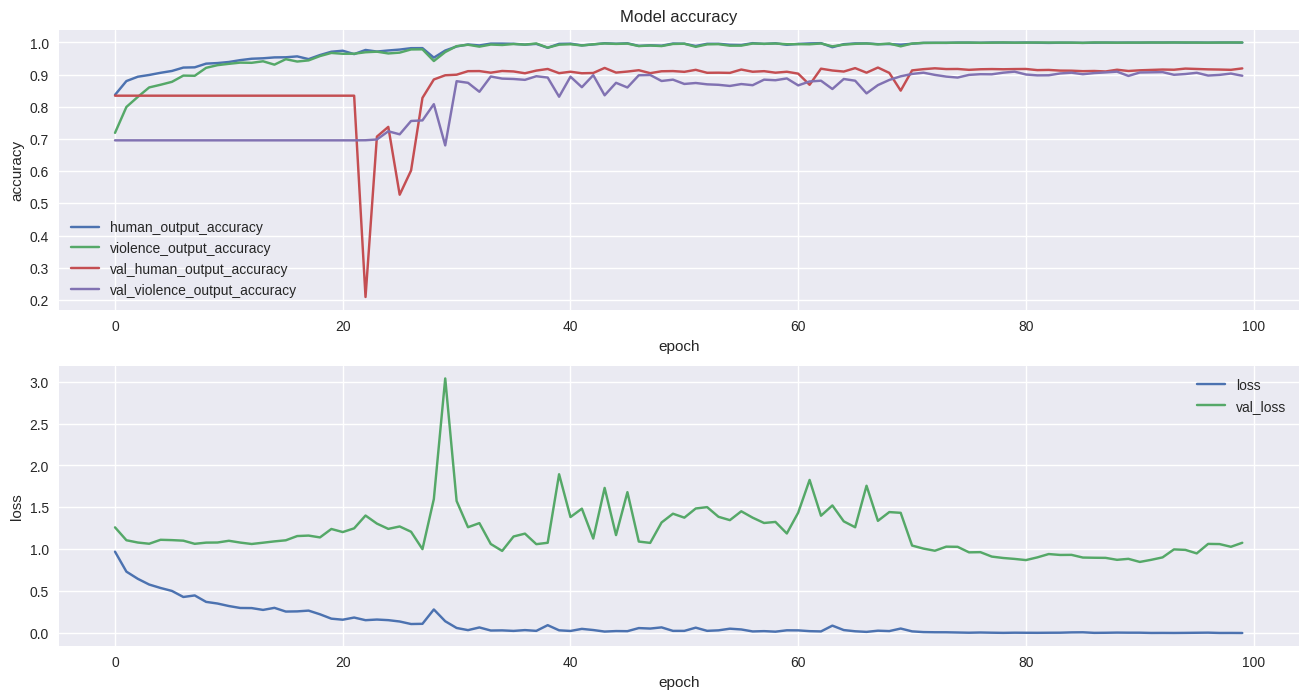

In [ ]:
#@title Plot accuracy and loss
plt.figure(figsize=(16, 8))

plt.subplot(2, 1, 1)
plt.plot(history.history["human_output_accuracy"])
plt.plot(history.history["violence_output_accuracy"])
plt.plot(history.history["val_human_output_accuracy"])
plt.plot(history.history["val_violence_output_accuracy"])

plt.title("Model accuracy")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend(
    [
        "human_output_accuracy",
        "violence_output_accuracy",
        "val_human_output_accuracy",
        "val_violence_output_accuracy"
    ],
    loc="best",
)

plt.subplot(2,1,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(
    [ 'loss', 'val_loss'],
    loc='best'
)

plt.show()

In [ ]:
#@title Save
model.save('/content/drive/MyDrive/dacs4/Datasets/plugin-for-kids/model/11.1.2023/model2.keras')
# !mkdir /content/drive/MyDrive/models/plugin-for-kids/09012024/
# !cp /content/model.keras /content/drive/MyDrive/models/plugin-for-kids/09012024/model.keras

# After

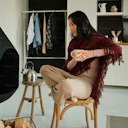

1/1 [==============================] - 0s 35ms/step
1 0
human , non-violence


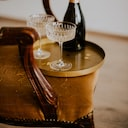

1/1 [==============================] - 0s 22ms/step
1 0
human , non-violence


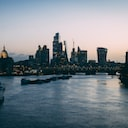

1/1 [==============================] - 0s 26ms/step
1 0
human , non-violence


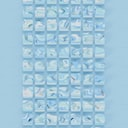

1/1 [==============================] - 0s 25ms/step
1 1
human , violence


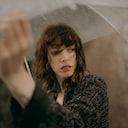

1/1 [==============================] - 0s 49ms/step
1 0
human , non-violence


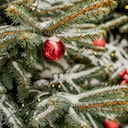

1/1 [==============================] - 0s 22ms/step
1 0
human , non-violence


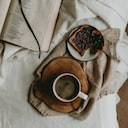

1/1 [==============================] - 0s 27ms/step
1 0
human , non-violence


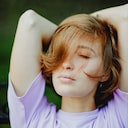

1/1 [==============================] - 0s 22ms/step
1 0
human , non-violence


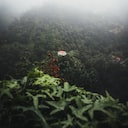

1/1 [==============================] - 0s 25ms/step
1 0
human , non-violence


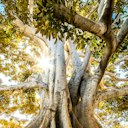

1/1 [==============================] - 0s 47ms/step
1 0
human , non-violence


In [ ]:
import requests

# response = requests.get("https://source.unsplash.com/random/128x128")
# file = open("test.jpg", "wb")
# file.write(response.content)
# file.close()

# cv2_imshow(cv2.imread("test.jpg"))

for _ in range(10):
    response = requests.get("https://source.unsplash.com/random/128x128")
    file = open("test.jpg", "wb")
    file.write(response.content)
    file.close()

    img = cv2.imread("test.jpg")
    print(test_img(model, "test.jpg"))